In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA

import keras

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["font.family"] = "DejaVu Sans"

# Загружаем исходный df
df = pd.read_csv("dataset.csv")
    
print(df.shape)
df.head()

(2766200, 13)


,user_id,server_time,idvisit,visitor_localtime,config_browser_engine,config_browser_name,config_device_brand,config_device_model,config_resolution,location_city,location_region,location_country,name
0,29c20dd3-a3bb-47ac-8c66-eedb8034de79,2021-08-01 07:01:05,51916058,06:57:50,WebKit,AN,TB,KE5,720x1600,Zapolyarnyy,MUR,ru,action_0
1,7eb7cdb7-0ade-4ef7-bd71-3464c0b74952,2021-08-01 07:01:05,51916088,07:01:05,WebKit,AN,HU,Honor 8A,720x1560,Ekaterinburg,SVE,ru,action_1
2,7eb7cdb7-0ade-4ef7-bd71-3464c0b74952,2021-08-01 07:01:06,51916088,07:01:05,WebKit,AN,HU,Honor 8A,720x1560,Ekaterinburg,SVE,ru,action_2
3,7eb7cdb7-0ade-4ef7-bd71-3464c0b74952,2021-08-01 07:01:11,51916088,07:01:05,WebKit,AN,HU,Honor 8A,720x1560,Ekaterinburg,SVE,ru,action_3
4,7eb7cdb7-0ade-4ef7-bd71-3464c0b74952,2021-08-01 07:01:14,51916088,07:01:05,WebKit,AN,HU,Honor 8A,720x1560,Ekaterinburg,SVE,ru,action_4


Выбор длины и количества сессий, отбор валидных для обучения пользователей: <br>
[Отбор пользователей](#otbor)


Загружаем датасет с отобранными пользователями  и учимся: <br>
[Обучение](#obuchenie)

Получив эмбеддинги, делаем кластеризацию: <br>
[Кластеризация и эмбеддинги](#clustering)



In [2]:
for columns in df.drop(columns = ['user_id', 'server_time', 'idvisit', 'name']).columns :
    if df[columns].dtype == 'O':
        df[columns] = df[columns].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2766200 entries, 0 to 2766199
Data columns (total 13 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   user_id                object  
 1   server_time            object  
 2   idvisit                int64   
 3   visitor_localtime      category
 4   config_browser_engine  category
 5   config_browser_name    category
 6   config_device_brand    category
 7   config_device_model    category
 8   config_resolution      category
 9   location_city          category
 10  location_region        category
 11  location_country       category
 12  name                   object  
dtypes: category(9), int64(1), object(3)
memory usage: 129.3+ MB


# Прежде чем загружать данные в skl, нужно избавиться от Nan. 

## Посмотрим их процентное содержание по столбцам: 


In [3]:
df.loc[:, "server_time" : "location_country"].isna().sum() / df.shape[0]

server_time              0.000000
idvisit                  0.000000
visitor_localtime        0.000000
config_browser_engine    0.094513
config_browser_name      0.000000
config_device_brand      0.495626
config_device_model      0.094471
config_resolution        0.000000
location_city            0.193623
location_region          0.156959
location_country         0.000000
dtype: float64

## Nan составляют половину от столбца "device_brand", при этом в ~90% случаев известна модель "device_model", возникает вопрос об удалении столбца.
## Посмотрим, какие значения может принимать столбец "бренд", когда "модель" неизвестна

In [4]:
df.query("~config_device_brand.isnull() & config_device_model.isnull()", engine='python').config_device_brand.unique()


[], Categories (33, object): ['1T', 'AL', 'AP', 'AU', ..., 'VV', 'VX', 'XI', 'ZT']

## Таким образом, если модель для пользователя является более сильной характеристикой, чем бренд, и от него можно избавляться. Остальные Nan заменим модой: 

In [5]:
df.drop(columns = "config_device_brand", inplace = True)

In [6]:
# Посмотрим какие ещё Nan осталось устранить
Nans_to_drop = (df.loc[:, "server_time" : "location_country"].isna().sum() / df.shape[0])[lambda x: x != 0].index.values

In [7]:
for columns in Nans_to_drop:
    df[columns] = df[columns].fillna(df[columns].mode()[0])

## Проверим все ли Nan ушли: 


In [8]:
df.loc[:, "server_time" : "location_country"].isna().sum() / df.shape[0]

server_time              0.0
idvisit                  0.0
visitor_localtime        0.0
config_browser_engine    0.0
config_browser_name      0.0
config_device_model      0.0
config_resolution        0.0
location_city            0.0
location_region          0.0
location_country         0.0
dtype: float64

# Избавились от Nan, теперь перемешаем исходный датасет и обработаем его, выбросим аномальные действия



In [9]:
df_shuffled = df[~df.name.isin(['action_0','action_6', 'action_7','action_27']) ].sample(frac=1).copy() # Убираем эти действия, т.к. ими спамят
df_shuffled.head()

,user_id,server_time,idvisit,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name
469064,dab524b1-f209-41b0-8f85-acb97af518d1,2021-08-05 17:27:47,52779261,17:26:54,WebKit,AN,generic mobile,1080x2340,Kirovgrad,SVE,ru,action_38
618241,7b825c12-6cc3-4b81-b3b7-7917a08ad295,2021-08-06 19:51:23,53066611,00:45:52,Blink,YA,generic desktop,1920x1080,Ekaterinburg,SVE,ru,action_239
1841433,f0520e7a-5642-48ab-8c3f-d12da89ad56c,2021-08-20 17:32:19,55289871,17:32:17,WebKit,AN,"GALAXY Tab A 8.0"" LTE (2019)",800x1280,Ekaterinburg,SVE,ru,action_2
1867855,edf7ab5d-24c4-4c2a-9417-75787a0de2f2,2021-08-20 21:30:52,55334834,21:30:52,WebKit,AN,Honor 10 Lite,1080x2340,Ekaterinburg,SVE,ru,action_1
2644433,181cffb7-a211-45a5-bfb2-d0da4a468caf,2021-08-30 23:07:41,56794080,02:06:39,Blink,OP,generic desktop,1366x768,Bryansk,BRY,ru,action_281


## Для каждого пользователя посчитаем частоту заходов в приложение (вероятно полезная характеристика)

### Необходимо произвести конкатенацию и сгрупппировать пользователей и сессии

In [10]:
df_shuffled_gb  = df_shuffled.groupby(["user_id", "idvisit"]).agg(lambda x: ','.join(x))
                                                            
df_shuffled_gb

server_time  \
user_id                              idvisit                                                       
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  2021-08-02 12:47:30,2021-08-02 12:47:49,2021-0...   
                                     53407017  2021-08-09 14:38:49,2021-08-09 14:38:27,2021-0...   
                                     53408013            2021-08-09 14:43:11,2021-08-09 14:43:26   
                                     53409031            2021-08-09 14:46:33,2021-08-09 14:47:13   
                                     53411519                                2021-08-09 14:59:12   
...                                                                                          ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                                2021-08-31 21:42:27   
                                     56986654  2021-09-01 01:07:53,2021-09-01 01:07:46,2021-0...   
                                     56986655                                2021-09-01 01:07:45   
                                     56995931  2021-09-01 03:40:18,2021-09-01 03:42:23,2021-0...   
                                     56995932                                2021-09-01 03:40:18   

                                                                               visitor_localtime  \
user_id                              idvisit                                                       
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  12:45:29,12:45:29,12:45:29,12:45:29,12:45:29,1...   
                                     53407017                         14:37:29,14:37:29,14:37:29   
                                     53408013                                  14:42:04,14:42:04   
                                     53409031                                  14:46:33,14:46:33   
                                     53411519                                           14:58:40   
...                                                                                          ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                                           21:42:27   
                                     56986654                01:07:45,01:07:45,01:07:45,01:07:45   
                                     56986655                                           01:07:45   
                                     56995931       03:40:18,03:40:18,03:40:18,03:40:18,03:40:18   
                                     56995932                                           03:40:18   

                                                                          config_browser_engine  \
user_id                              idvisit                                                      
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  WebKit,WebKit,WebKit,WebKit,WebKit,WebKit,WebKit   
                                     53407017                              WebKit,WebKit,WebKit   
                                     53408013                                     WebKit,WebKit   
                                     53409031                                     WebKit,WebKit   
                                     53411519                                            WebKit   
...                                                                                         ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                                            WebKit   
                                     56986654                       WebKit,WebKit,WebKit,WebKit   
                                     56986655                                            WebKit   
                                     56995931                WebKit,WebKit,WebKit,WebKit,WebKit   
                                     56995932                                            WebKit   

                                                config_browser_name  \
user_id                              idvisit                          
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  AN,AN,

### В течение каждой сессии пользователь совершает множество действий, при этом каждое маркируется временем. Чтобы оценить частоту использования приложения, отбросим все дубликаты, оставив в каждой сессии только 1ое действие

In [11]:
timestamps = [x[0] for x in df_shuffled_gb.server_time.str.split(",")]  
df_shuffled_gb.server_time = timestamps

timestamps = [x[0] for x in df_shuffled_gb.visitor_localtime.str.split(",")]  
df_shuffled_gb.visitor_localtime = timestamps

df_shuffled_gb

server_time  \
user_id                              idvisit                         
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  2021-08-02 12:47:30   
                                     53407017  2021-08-09 14:38:49   
                                     53408013  2021-08-09 14:43:11   
                                     53409031  2021-08-09 14:46:33   
                                     53411519  2021-08-09 14:59:12   
...                                                            ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104  2021-08-31 21:42:27   
                                     56986654  2021-09-01 01:07:53   
                                     56986655  2021-09-01 01:07:45   
                                     56995931  2021-09-01 03:40:18   
                                     56995932  2021-09-01 03:40:18   

                                              visitor_localtime  \
user_id                              idvisit                      
000d60c9-0922-4b11-88bd-248ebaa15560 52061805          12:45:29   
                                     53407017          14:37:29   
                                     53408013          14:42:04   
                                     53409031          14:46:33   
                                     53411519          14:58:40   
...                                                         ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104          21:42:27   
                                     56986654          01:07:45   
                                     56986655          01:07:45   
                                     56995931          03:40:18   
                                     56995932          03:40:18   

                                                                          config_browser_engine  \
user_id                              idvisit                                                      
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  WebKit,WebKit,WebKit,WebKit,WebKit,WebKit,WebKit   
                                     53407017                              WebKit,WebKit,WebKit   
                                     53408013                                     WebKit,WebKit   
                                     53409031                                     WebKit,WebKit   
                                     53411519                                            WebKit   
...                                                                                         ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                                            WebKit   
                                     56986654                       WebKit,WebKit,WebKit,WebKit   
                                     56986655                                            WebKit   
                                     56995931                WebKit,WebKit,WebKit,WebKit,WebKit   
                                     56995932                                            WebKit   

                                                config_browser_name  \
user_id                              idvisit                          
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  AN,AN,AN,AN,AN,AN,AN   
                                     53407017              AN,AN,AN   
                                     53408013                 AN,AN   
                                     53409031                 AN,AN   
                                     53411519                    AN   
...                                                             ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                    AN   
                                     56986654           AN,AN,AN,AN   
                                     56986655                    AN   
                                     56995931        AN,AN,AN,AN,AN   
                                     56995932                    AN   

                                                            

### А во всех остальных колонках уберем дубли, кроме колонки "действия", где они имеют смысл

In [12]:
for col in df_shuffled_gb.columns[2:-1]:
    unique = list()
    for lists in df_shuffled_gb[col].str.split(",") :
        unique.append(lists[0])
    df_shuffled_gb[col] = unique   

#### Теперь переведем время сервера в часы

In [13]:
df_shuffled_gb.server_time = pd.to_datetime(df_shuffled_gb.server_time).astype(np.int64) / 10**9 / 60 / 60 / 24
df_shuffled_gb

C:\Users\kalmy\AppData\Local\Temp/ipykernel_10260/2836000755.py:1: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_shuffled_gb.server_time = pd.to_datetime(df_shuffled_gb.server_time).astype(np.int64) / 10**9 / 60 / 60 / 24


server_time visitor_localtime  \
user_id                              idvisit                                    
000d60c9-0922-4b11-88bd-248ebaa15560 52061805  18841.532986          12:45:29   
                                     53407017  18848.610289          14:37:29   
                                     53408013  18848.613322          14:42:04   
                                     53409031  18848.615660          14:46:33   
                                     53411519  18848.624444          14:58:40   
...                                                     ...               ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104  18870.904479          21:42:27   
                                     56986654  18871.047141          01:07:45   
                                     56986655  18871.047049          01:07:45   
                                     56995931  18871.152986          03:40:18   
                                     56995932  18871.152986          03:40:18   

                                              config_browser_engine  \
user_id                              idvisit                          
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                WebKit   
                                     53407017                WebKit   
                                     53408013                WebKit   
                                     53409031                WebKit   
                                     53411519                WebKit   
...                                                             ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                WebKit   
                                     56986654                WebKit   
                                     56986655                WebKit   
                                     56995931                WebKit   
                                     56995932                WebKit   

                                              config_browser_name  \
user_id                              idvisit                        
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                  AN   
                                     53407017                  AN   
                                     53408013                  AN   
                                     53409031                  AN   
                                     53411519                  AN   
...                                                           ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                  AN   
                                     56986654                  AN   
                                     56986655                  AN   
                                     56995931                  AN   
                                     56995932                  AN   

                                              config_device_model  \
user_id                              idvisit                        
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                MI 6   
                                     53407017                MI 6   
                                     53408013                MI 6   
                                     53409031                MI 6   
                                     53411519                MI 6   
...                                                           ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104          GALAXY A10   
                                     56986654          GALAXY A10   
                                     56986655          GALAXY A10   
                                     56995931          GALAXY A10   
                                     56995932          GALAXY A10   

                                              config_resolution  \
user_id                              idvisit                      
000d60c9-0922-4b11-88bd-248ebaa15560 52061805         1080x1920   
                                     53407017         1080x1920   
      

In [14]:
zahod = df_shuffled_gb.groupby("user_id")["server_time"].apply(np.diff).apply(abs).apply(np.mean) 
zahod = pd.DataFrame(zahod).rename(columns = {"server_time": "online_delta"})

In [15]:
zahod.join(df_shuffled_gb, how = "inner").name.str.split(",").values

array([list(['action_108', 'action_29', 'action_108', 'action_108', 'action_108', 'action_108', 'action_108']),
       list(['action_17', 'action_29', 'action_1']),
       list(['action_29', 'action_17']), ..., list(['action_5']),
       list(['action_1', 'action_25', 'action_25', 'action_2', 'action_4']),
       list(['action_5'])], dtype=object)

In [16]:
df_filtered = zahod.join(df_shuffled_gb, how = "inner")
df_filtered.name = df_filtered.name.str.split(",")
df_filtered

online_delta   server_time  \
user_id                              idvisit                                
000d60c9-0922-4b11-88bd-248ebaa15560 52061805      1.017829  18841.532986   
                                     53407017      1.017829  18848.610289   
                                     53408013      1.017829  18848.613322   
                                     53409031      1.017829  18848.615660   
                                     53411519      1.017829  18848.624444   
...                                                     ...           ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104      0.123969  18870.904479   
                                     56986654      0.123969  18871.047141   
                                     56986655      0.123969  18871.047049   
                                     56995931      0.123969  18871.152986   
                                     56995932      0.123969  18871.152986   

                                              visitor_localtime  \
user_id                              idvisit                      
000d60c9-0922-4b11-88bd-248ebaa15560 52061805          12:45:29   
                                     53407017          14:37:29   
                                     53408013          14:42:04   
                                     53409031          14:46:33   
                                     53411519          14:58:40   
...                                                         ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104          21:42:27   
                                     56986654          01:07:45   
                                     56986655          01:07:45   
                                     56995931          03:40:18   
                                     56995932          03:40:18   

                                              config_browser_engine  \
user_id                              idvisit                          
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                WebKit   
                                     53407017                WebKit   
                                     53408013                WebKit   
                                     53409031                WebKit   
                                     53411519                WebKit   
...                                                             ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                WebKit   
                                     56986654                WebKit   
                                     56986655                WebKit   
                                     56995931                WebKit   
                                     56995932                WebKit   

                                              config_browser_name  \
user_id                              idvisit                        
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                  AN   
                                     53407017                  AN   
                                     53408013                  AN   
                                     53409031                  AN   
                                     53411519                  AN   
...                                                           ...   
fff7eb64-efa1-438b-8fd2-20d52a34f653 56959104                  AN   
                                     56986654                  AN   
                                     56986655                  AN   
                                     56995931                  AN   
                                     56995932                  AN   

                                              config_device_model  \
user_id                              idvisit                        
000d60c9-0922-4b11-88bd-248ebaa15560 52061805                MI 6   
                                     53407017                MI 6   
                                     53408013                MI 6   
      

# Настало время выбрать пользователей и сессии, на которых будет учиться нейронка. Изучим вероятные значения длин сессий и количества сессий:


In [17]:
lenghts = [len(x) for x in df_filtered.name]
pd.DataFrame(data = lenghts).describe()

,0
count,620340.000000
mean,3.544995
std,8.669000
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,829.000000


## Как видим, 75ый квантиль соответствует длине сессии в 4 действия, однако максимум > 800 действий. Это явные выбросы. Выбросим 5% самых длинных сессий.

Квантиль 95:  10.0


<AxesSubplot:xlabel='lengths', ylabel='online_delta'>

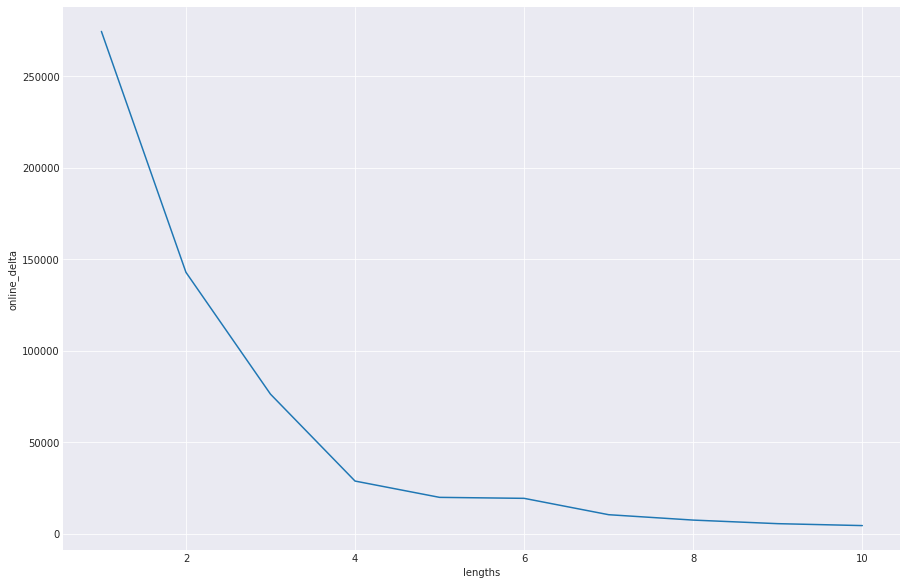

In [18]:
df_filtered["lengths"] = [len(x) for x in df_filtered.name]
quantile_95 = df_filtered.lengths.quantile(.95)
print("Квантиль 95: ", quantile_95)

counted_lenghts = pd.DataFrame(df_filtered.query("lengths <= @quantile_95").groupby("lengths", as_index = False)["online_delta"].count())
sns.lineplot(x = counted_lenghts.lengths, y = counted_lenghts.online_delta) 

#График показывает уже с отброшенными 5%

In [19]:
# Количество визитов на каждую длину сессии
pd.DataFrame(counted_lenghts.rename(columns = {'online_delta' : 'observations'}))

,lengths,observations
0,1,274416
1,2,142842
2,3,76292
3,4,28829
4,5,19921
5,6,19385
6,7,10452
7,8,7507
8,9,5557
9,10,4504


In [20]:
# Посмотрим на самых отчаянных
df_filtered.query('lengths > 800')
strange_fellow = df_filtered.query('lengths > 800').index.get_level_values(0)[0]

In [21]:
df_filtered.loc[strange_fellow,:].sort_values("lengths", ascending = False).head(3)

,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
idvisit,,,,,,,,,,,,
55928208,0.275488,18864.665544,17:55:34,Blink,CH,generic desktop,1920x1080,Ulyanovsk,ULY,ru,"[action_440, action_632, action_441, action_16...",829
55654718,0.275488,18862.803843,22:36:56,Blink,CH,generic desktop,1920x1080,Ulyanovsk,ULY,ru,"[action_108, action_76, action_161, action_82,...",418
55768131,0.275488,18863.612187,18:10:49,Blink,CH,generic desktop,1920x1080,Ulyanovsk,ULY,ru,"[action_290, action_80, action_104, action_104...",156


## Изучим количество сессий 

In [22]:
df_filtered.groupby("user_id")["config_browser_name"].count().describe()

count    3348.000000
mean      185.286738
std       152.774974
min         4.000000
25%        62.000000
50%       145.000000
75%       273.000000
max      1178.000000
Name: config_browser_name, dtype: float64

<AxesSubplot:xlabel='config_browser_name', ylabel='Density'>

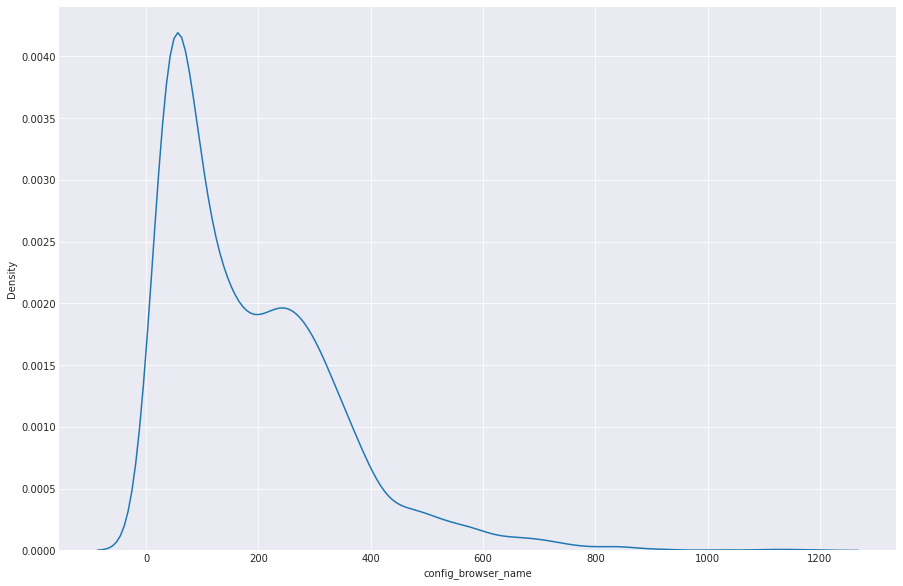

In [23]:
sessions_amount = df_filtered.groupby("user_id")["config_browser_name"].count()
sns.kdeplot(sessions_amount)

## Выберем интервал по количеству сессий и их длине для тех, кто пойдет в train

In [33]:
df_filtered.reset_index().to_pickle('df_filtered.pkl')  # Сохраняем, чтобы каждый раз не обрабатывать заново


## **Отбор пользователей**<a name='otbor'></a>

In [34]:
df_filtered = pd.read_pickle('df_filtered.pkl')

In [35]:
df_filtered

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
0,000d60c9-0922-4b11-88bd-248ebaa15560,52061805,1.017829,18841.532986,12:45:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_108, action_29, action_108, action_108...",7
1,000d60c9-0922-4b11-88bd-248ebaa15560,53407017,1.017829,18848.610289,14:37:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_17, action_29, action_1]",3
2,000d60c9-0922-4b11-88bd-248ebaa15560,53408013,1.017829,18848.613322,14:42:04,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_29, action_17]",2
3,000d60c9-0922-4b11-88bd-248ebaa15560,53409031,1.017829,18848.615660,14:46:33,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_1, action_17]",2
4,000d60c9-0922-4b11-88bd-248ebaa15560,53411519,1.017829,18848.624444,14:58:40,WebKit,AN,MI 6,1080x1920,Ekaterinburg,SVE,ru,[action_29],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620335,fff7eb64-efa1-438b-8fd2-20d52a34f653,56959104,0.123969,18870.904479,21:42:27,WebKit,AN,GALAXY A10,unknown,Ekaterinburg,SVE,ru,[action_5],1
620336,fff7eb64-efa1-438b-8fd2-20d52a34f653,56986654,0.123969,18871.047141,01:07:45,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_4, action_2, action_46, action_1]",4
620337,fff7eb64-efa1-438b-8fd2-20d52a34f653,56986655,0.123969,18871.047049,01:07:45,WebKit,AN,GALAXY A10,unknown,Ekaterinburg,SVE,ru,[action_5],1
620338,fff7eb64-efa1-438b-8fd2-20d52a34f653,56995931,0.123969,18871.152986,03:40:18,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_1, action_25, action_25, action_2, act...",5


In [36]:
# Получаем список тех пользователей, у кого количество сессий от __ и до __:
print("Введите через пробел интервал-ограничение на количество сессий (обычно 100-450): ")
floor, roof = (input().split(sep = ' '))
floor = int(floor)
roof = int(roof)

valid_users =  df_filtered.groupby("user_id")["online_delta"].count().where(lambda x : x >= floor) \
                                                            .where(lambda x : x <= roof).dropna().index.values

Введите через пробел интервал-ограничение на количество сессий (обычно 100-450): 
100 450


In [37]:
valid_users

array(['00208c67-09f4-42e4-9378-d267aab64e54',
       '0021f4a7-298c-4a15-bf5f-fe510da61284',
       '006c0526-73f4-4c5b-b404-738f5ba941d0', ...,
       'ffc72084-89ea-4ddf-9921-21c9a6dfe10f',
       'fff775ab-2825-4e7a-a0d6-196ccf260d1d',
       'fff7eb64-efa1-438b-8fd2-20d52a34f653'], dtype=object)

In [38]:
df_filtered

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
0,000d60c9-0922-4b11-88bd-248ebaa15560,52061805,1.017829,18841.532986,12:45:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_108, action_29, action_108, action_108...",7
1,000d60c9-0922-4b11-88bd-248ebaa15560,53407017,1.017829,18848.610289,14:37:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_17, action_29, action_1]",3
2,000d60c9-0922-4b11-88bd-248ebaa15560,53408013,1.017829,18848.613322,14:42:04,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_29, action_17]",2
3,000d60c9-0922-4b11-88bd-248ebaa15560,53409031,1.017829,18848.615660,14:46:33,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[action_1, action_17]",2
4,000d60c9-0922-4b11-88bd-248ebaa15560,53411519,1.017829,18848.624444,14:58:40,WebKit,AN,MI 6,1080x1920,Ekaterinburg,SVE,ru,[action_29],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620335,fff7eb64-efa1-438b-8fd2-20d52a34f653,56959104,0.123969,18870.904479,21:42:27,WebKit,AN,GALAXY A10,unknown,Ekaterinburg,SVE,ru,[action_5],1
620336,fff7eb64-efa1-438b-8fd2-20d52a34f653,56986654,0.123969,18871.047141,01:07:45,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_4, action_2, action_46, action_1]",4
620337,fff7eb64-efa1-438b-8fd2-20d52a34f653,56986655,0.123969,18871.047049,01:07:45,WebKit,AN,GALAXY A10,unknown,Ekaterinburg,SVE,ru,[action_5],1
620338,fff7eb64-efa1-438b-8fd2-20d52a34f653,56995931,0.123969,18871.152986,03:40:18,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_1, action_25, action_25, action_2, act...",5


In [39]:
# Добавляем ограничение на длины сессий
print("Введите через пробел интервал-ограничение на длину сессий (обычно 3-10): ")
floor, roof = (input().split(sep = ' '))
floor = int(floor)
roof = int(roof)

df_valid_users = df_filtered[df_filtered["user_id"].isin(valid_users)] \
                                        .query("lengths >= @floor & lengths<= @roof").copy()

Введите через пробел интервал-ограничение на длину сессий (обычно 3-10): 
3 10


In [41]:
df_valid_users

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
32,00208c67-09f4-42e4-9378-d267aab64e54,51952032,0.078875,18840.611412,14:39:56,WebKit,AN,Blade A5 2019RU,720x1440,Moscow,MOW,ru,"[action_22, action_3, action_4, action_2, acti...",5
62,00208c67-09f4-42e4-9378-d267aab64e54,52087190,0.078875,18841.577812,13:51:57,WebKit,AN,Blade A5 2019RU,720x1440,Moscow,MOW,ru,"[action_4, action_2, action_1]",3
76,00208c67-09f4-42e4-9378-d267aab64e54,52147919,0.078875,18841.688542,16:31:29,WebKit,AN,Blade A5 2019RU,720x1440,Moscow,MOW,ru,"[action_2, action_1, action_4, action_10, acti...",6
78,00208c67-09f4-42e4-9378-d267aab64e54,52173307,0.078875,18841.731227,17:32:58,WebKit,AN,Blade A5 2019RU,720x1440,Moscow,MOW,ru,"[action_1, action_10, action_4, action_2, acti...",6
80,00208c67-09f4-42e4-9378-d267aab64e54,52191580,0.078875,18841.764641,18:21:05,WebKit,AN,Blade A5 2019RU,720x1440,Moscow,MOW,ru,"[action_1, action_11, action_9, action_10, act...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620330,fff7eb64-efa1-438b-8fd2-20d52a34f653,56955600,0.123969,18870.891447,21:23:34,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_4, action_1, action_50, action_2719, a...",6
620332,fff7eb64-efa1-438b-8fd2-20d52a34f653,56958412,0.123969,18870.901806,21:38:32,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_4, action_1, action_2]",3
620334,fff7eb64-efa1-438b-8fd2-20d52a34f653,56959103,0.123969,18870.905718,21:42:27,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_46, action_1, action_46, action_47, ac...",10
620336,fff7eb64-efa1-438b-8fd2-20d52a34f653,56986654,0.123969,18871.047141,01:07:45,WebKit,AN,GALAXY A10,720x1520,Ekaterinburg,SVE,ru,"[action_4, action_2, action_46, action_1]",4


# Теперь для валидных пользователей построим первичные энкодинги и подготовим данные к загрузке в нейросеть

In [42]:
# Выбираем топ N пользователей по количеству сессий
print("Введите количество таргет-классов для semi-supervised задачи о классификации пользователя: ")
how_many_users = int(input())

unique_ids, counts = np.unique(df_valid_users["user_id"], return_counts=True)
top_n_users_ids = pd.DataFrame(counts,unique_ids).sort_values(by = 0, ascending=False).index[0:how_many_users]

# И смотрим, как много у них сессий (оцениваем баланс классов)
pd.DataFrame(counts, unique_ids).sort_values(by = 0, ascending=False).rename(columns = {0 : 'Sessions amount'}).head(how_many_users)

Введите количество таргет-классов для semi-supervised задачи о классификации пользователя: 
20


,Sessions amount
7bb9b3ae-5b0c-4a39-a634-f07f028002e0,313
1a6e09cf-a305-41c6-b076-2a4db5d95aa3,288
94fe79d9-8d13-40e8-9a56-811cf47c2661,274
8096fc4b-852a-418d-957f-17b06d83a081,262
a2a2afae-e1ec-42a3-b0e4-8387b0e9f41b,261
eb9ad0a8-22ab-459b-9bbf-20f47a192daa,256
88938b0b-6b2b-45a7-a47e-fe2280c20e6a,249
74279bac-321b-48c3-b0f0-1271b1c48f50,246
14aea0d0-d206-442f-8741-4334f1da753a,236
0cf8754b-a522-4968-8e5e-13e47ada7b42,228


In [43]:
top_n_users_df = df_valid_users[df_valid_users["user_id"].isin(top_n_users_ids)].sample(frac=1, random_state = 42)
top_n_users_df.head(2)

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
234132,61183f38-70f3-4398-8695-40ccb1dad5b1,54156474,0.086823,18852.64794,20:33:01,WebKit,UNK,generic desktop,414x896,Kamensk-Ural'skiy,SVE,ru,"[action_32, action_2, action_31]",3
345734,90ca9152-8f01-461b-9c1f-e86d6993aa90,54945951,0.070787,18857.66375,20:55:48,WebKit,UNK,generic desktop,375x812,Ekaterinburg,SVE,ru,"[action_31, action_2, action_32]",3


In [44]:
le = preprocessing.LabelEncoder()
for col in top_n_users_df.drop(columns = ['name', 'visitor_localtime', 'user_id']).columns :
    if top_n_users_df[col].dtype == "O":                        
        top_n_users_df[col] = le.fit_transform(top_n_users_df[col].values)


In [45]:
# Энкодим все категориальные столбцы 
for col in top_n_users_df.drop(columns = ['name', 'visitor_localtime', 'user_id']).columns :
    if top_n_users_df[col].dtype == "O":                        
        top_n_users_df[col] = le.fit_transform(top_n_users_df[col].values)
        

In [46]:
# Колонку name развернем в столбцы

length_of_actions = top_n_users_df.lengths.max()
new_columns = []
for i in range(1, length_of_actions+1):
    new_columns.append(("column_new_" + str(i),[0]))
new_columns = dict(new_columns)
top_n_users_df = top_n_users_df.join(pd.DataFrame(new_columns, index = top_n_users_df.index))

for row, lists in tqdm(enumerate(top_n_users_df.name.values)):
    for index, value in enumerate(lists) : 
        top_n_users_df["column_new_" + str(index+1)].iloc[row] = value
        
top_n_users_df.drop(columns = "name", inplace = True)
top_n_users_df.head(2)  

0it [00:00, ?it/s]C:\Users\kalmy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
4596it [00:02, 1798.75it/s]


,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,...,column_new_1,column_new_2,column_new_3,column_new_4,column_new_5,column_new_6,column_new_7,column_new_8,column_new_9,column_new_10
234132,61183f38-70f3-4398-8695-40ccb1dad5b1,54156474,0.086823,18852.64794,20:33:01,2,4,7,14,7,...,action_32,action_2,action_31,0,0,0,0,0,0,0
345734,90ca9152-8f01-461b-9c1f-e86d6993aa90,54945951,0.070787,18857.66375,20:55:48,2,4,7,11,4,...,action_31,action_2,action_32,0,0,0,0,0,0,0


In [47]:
top_n_users_df

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,...,column_new_1,column_new_2,column_new_3,column_new_4,column_new_5,column_new_6,column_new_7,column_new_8,column_new_9,column_new_10
234132,61183f38-70f3-4398-8695-40ccb1dad5b1,54156474,0.086823,18852.647940,20:33:01,2,4,7,14,7,...,action_32,action_2,action_31,0,0,0,0,0,0,0
345734,90ca9152-8f01-461b-9c1f-e86d6993aa90,54945951,0.070787,18857.663750,20:55:48,2,4,7,11,4,...,action_31,action_2,action_32,0,0,0,0,0,0,0
292828,7ad49ffd-1579-45c2-8a33-b0516464be3b,55304374,0.068318,18859.783310,18:47:55,2,0,5,2,4,...,action_4,action_2,action_1,0,0,0,0,0,0,0
53007,14aea0d0-d206-442f-8741-4334f1da753a,54388049,0.098774,18853.961609,04:04:40,2,4,7,12,4,...,action_32,action_10,action_28,action_1,0,0,0,0,0,0
67719,1a6e09cf-a305-41c6-b076-2a4db5d95aa3,52868082,0.060925,18844.942199,22:36:23,2,0,0,17,4,...,action_4,action_2,action_1,action_20,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571305,eb9ad0a8-22ab-459b-9bbf-20f47a192daa,53691610,0.108034,18849.882569,02:10:49,2,4,7,10,4,...,action_32,action_2,action_1,0,0,0,0,0,0,0
52942,14aea0d0-d206-442f-8741-4334f1da753a,53447104,0.098774,18848.731539,20:32:53,2,4,7,12,19,...,action_10,action_32,action_21,action_1,action_28,action_10,action_11,action_28,0,0
355712,94fe79d9-8d13-40e8-9a56-811cf47c2661,54235708,0.090795,18852.849340,22:23:03,2,4,7,8,4,...,action_31,action_2,action_32,0,0,0,0,0,0,0
481605,c7c0f3a9-497b-4161-b3a5-1d1ac533b6aa,54158342,0.111891,18852.653287,15:40:40,2,0,8,1,4,...,action_2,action_29,action_11,action_4,action_12,action_4,action_33,0,0,0


In [48]:
#Берем только пользователей в топ N, добавляем имя в качестве столбца
top_n_users_df.to_pickle('Born_to_train.pkl') # df с учетом выбора длины сессии, их количества, и выборкой пользователей, готов сразу в модель

# **Обучение:** <a name='obuchenie'></a>

In [49]:
Born_to_train = pd.read_pickle('Born_to_train.pkl')
    
top_n_users_df = Born_to_train
how_many_users = len(top_n_users_df.user_id.unique())

In [50]:
print(f'Отобраны {how_many_users} первых пользователей, \n\
        длина сессий от {top_n_users_df.lengths.unique().min()} до {top_n_users_df.lengths.unique().max()} \n\
        и кол-во сессий от {top_n_users_df.groupby(by = "user_id")["idvisit"].count().min()} до {top_n_users_df.groupby(by = "user_id")["idvisit"].count().max()}')

Отобраны 20 первых пользователей, 
        длина сессий от 3 до 10 
        и кол-во сессий от 188 до 313


In [51]:
# Отбираем только поведенческие фичи
y = top_n_users_df.loc[:, 'user_id'] # Угадывать будем user_id
X = top_n_users_df.loc[:, 'column_new_1' : 'column_new_8' ] # По поведению
X = X.applymap(lambda x: str(x)) # Всё запихнем в строки для токенайзера
print(X.head(3),'\n\n', y.head(3))


       column_new_1 column_new_2 column_new_3 column_new_4 column_new_5  \
234132    action_32     action_2    action_31            0            0   
345734    action_31     action_2    action_32            0            0   
292828     action_4     action_2     action_1            0            0   

       column_new_6 column_new_7 column_new_8  
234132            0            0            0  
345734            0            0            0  
292828            0            0            0   

 234132    61183f38-70f3-4398-8695-40ccb1dad5b1
345734    90ca9152-8f01-461b-9c1f-e86d6993aa90
292828    7ad49ffd-1579-45c2-8a33-b0516464be3b
Name: user_id, dtype: object


In [52]:
# Делаем сплит на тестовую и тренировочную выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

# Энкодим таргет, то есть имена пользователей, и преобразуем всё в numpy - массивы
from sklearn import preprocessing
le_for_target_users_ids = preprocessing.LabelEncoder()

y_train = le_for_target_users_ids.fit_transform(y_train)
y_test = le_for_target_users_ids.transform(y_test)
y_test
X_train, X_test = X_train.values, X_test.values

# Подрубаем нейронку

<a name="Otbor"></a>

In [53]:
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LSTM, SimpleRNN, GRU
from keras.layers import Concatenate, Reshape, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras import regularizers 
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [54]:
# Ставим seed на всё, чтобы оценивать качество сети
import numpy as np
import tensorflow as tf
import random as rn
import os

def reset_seeds(seed):
    
    os.environ['PYTHONHASHSEED'] = str(seed) #Для хэширования
    np.random.seed(seed) 
    rn.seed(seed)
    tf.compat.v1.set_random_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
  

In [55]:
# Посмотрим, в каком формате сделан train - датасет.
print("Shape: ", X_train.shape)
X_train

Shape:  (3079, 8)


array([['action_32', 'action_2', 'action_1', ..., '0', '0', '0'],
       ['action_31', 'action_32', 'action_2', ..., '0', '0', '0'],
       ['action_4', 'action_2', 'action_31', ..., '0', '0', '0'],
       ...,
       ['action_4', 'action_1', 'action_2', ..., '0', '0', '0'],
       ['action_2', 'action_4', 'action_1', ..., '0', '0', '0'],
       ['action_32', 'action_2', 'action_21', ..., 'action_10',
        'action_1', 'action_1']], dtype=object)

In [56]:
# Включаем GPU по необходимости
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found') 
#print('Found GPU at: {}'.format(device_name))


In [57]:
# Массив для хранения результатов
import pickle
import os

pkl_file = 'all_best_runs_history.pkl'

if os.path.getsize(pkl_file) > 0: # Если файл не пустой, подгружаем туда историю из pickle
    output = open(pkl_file, 'rb')
    all_best_runs_history = pickle.load(output)
    output.close()
else: 
    all_best_runs_history = []


In [58]:
def create_model(random_seed, type):    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005)
    tokenizer = tf.keras.layers.StringLookup(vocabulary = np.append(df.name.unique(), '0'))
    emb_initializer = tf.keras.initializers.TruncatedNormal(mean = 0., stddev = 0.5, seed = random_seed )
    kernel_initializer = tf.keras.initializers.TruncatedNormal(mean= 0., stddev = 0.5, seed = random_seed )
    
    model = Sequential([tokenizer])
    model.add(Embedding(
                input_dim = tokenizer.vocabulary_size(), # 2802 слов в словаре 
                output_dim = embedding_size, 
                input_length = X_train.shape[1], # Длина входной последовательности
                name="embedding",
                embeddings_initializer = emb_initializer))

    if type == 1: # Dense model

        model.add(Flatten()) # Эта штука выравнивает выход для Dense слоя
        model.add(Dropout(.2))
        model.add(Dense(units = embedding_size, activation = 'relu', kernel_initializer = kernel_initializer))
        model.add(Dense(units = how_many_users, activation = 'softmax', kernel_initializer = kernel_initializer ))

    if type == 2: # 'RNN' model
        model.add(Dropout(.1))
        model.add(GRU(embedding_size, activation = 'relu', kernel_initializer = kernel_initializer)) 
        model.add(Dense(units = how_many_users, activation = 'softmax', kernel_initializer = kernel_initializer ))
        
        
    model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ["accuracy"])
    return model 

In [59]:
# Обучаем модель
from tqdm import tqdm
global embedding_size

embedding_size = 5
epochs_amount = 100


model_type = 2
print(f'Архитектура модели:\n 1 - Dense \n 2 - RNN \n Сейчас установлен:{model_type}')
best_model = 0

from random import randint

callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 10)

best_run_info = [0]
for random_seed in tqdm([871 for i in range(1)]): 
    # Берем 10 случайных сидов из большого промежутка: randint(1,10000) for i in range(10)
    reset_seeds(random_seed) 
    model = create_model(random_seed, model_type)
    
    history = model.fit(X_train, y_train, epochs = epochs_amount, verbose = 0, callbacks = callback)
    predict_x = model.predict(X_test) 
    classes_predicted = np.argmax(predict_x,axis=1)
    
    prec = precision_score(y_test, classes_predicted, average = "macro", zero_division = 0)
    rec = recall_score(y_test, classes_predicted, average = "macro", zero_division = 0)
    f1_scr = f1_score(y_test, classes_predicted, average = "macro", zero_division = 0)
    
    if f1_scr > best_run_info[0]:
        best_seed = random_seed
        best_model = model
        best_run_info = [f1_scr, rec, prec, embedding_size, epochs_amount, model_type]
        best_machine_history = history
print(f"precision, recall, f1: {best_run_info[0:3]} , emb_size, epochs_am, model_type: {best_run_info[3:]} and best seed is: {best_seed}")

all_best_runs_history.append((best_run_info,best_seed))

Архитектура модели:
 1 - Dense 
 2 - RNN 
 Сейчас установлен:2


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.37s/it]

precision, recall, f1: [0.34549518571599264, 0.3999065123266566, 0.480684576758717] , emb_size, epochs_am, model_type: [5, 100, 2] and best seed is: 871


In [60]:
all_best_runs_history

[([0.40903219938749197, 0.4328364409171507, 0.5593965635773102, 5, 100, 2],
  93929),
 ([0.34549518571599264, 0.3999065123266566, 0.480684576758717, 5, 100, 2],
  871)]

In [61]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 string_lookup (StringLookup  (None, 8)                0         
 )                                                               
                                                                 
 embedding (Embedding)       (None, 8, 5)              14010     
                                                                 
 dropout (Dropout)           (None, 8, 5)              0         
                                                                 
 gru (GRU)                   (None, 5)                 180       
                                                                 
 dense (Dense)               (None, 20)                120       
                                                                 
Total params: 14,310
Trainable params: 14,310
Non-trainable params: 0
____________________________________________________

In [62]:
# сохраняем историю запусков, чтобы можно было повторять результаты
pkl_file = 'all_best_runs_history.pkl'
output = open(pkl_file, 'ab')
pickle.dump(all_best_runs_history, output)
output.close()

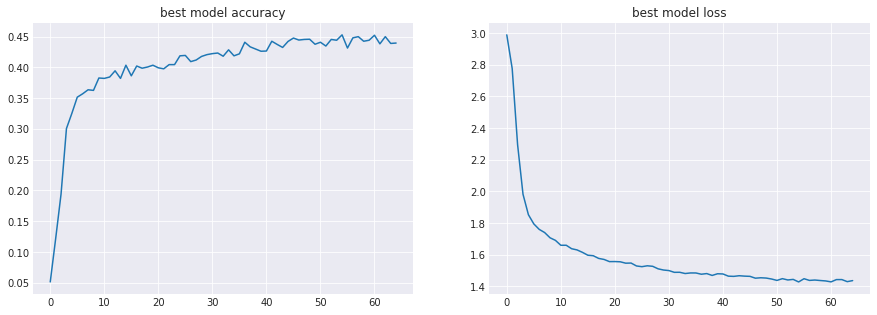

In [63]:
fig = plt.figure(figsize = (15,5))

ax = fig.add_subplot(1,2,1)
ax.set(title = 'best model accuracy')

ax2 = fig.add_subplot(1,2,2)
ax2.set(title = 'best model loss')

ax.plot(best_machine_history.history["accuracy"])
ax2.plot(best_machine_history.history["loss"])
plt.show()


## Модель получена, достанем из неё эмбеддинг слой и протестируем вектора


In [64]:
# Сохраняем модельку
best_model.save("predict_users_labels.h5")

In [65]:
# Подгружаем и проверяем качество
best_model = keras.models.load_model("predict_users_labels.h5")

predict_x = best_model.predict(X_test)
classes_predicted = np.argmax(predict_x,axis=1)

prec = precision_score(y_test, classes_predicted, average = "macro", zero_division = 0)
rec = recall_score(y_test, classes_predicted, average = "macro", zero_division = 0)
f1_scr = f1_score(y_test, classes_predicted, average = "macro", zero_division = 0)
print(prec,rec,f1_scr)

0.480684576758717 0.3999065123266566 0.34549518571599264


In [66]:
# Достаём эмбеддинг машину
layer_name = 'embedding'
embedding_machine = Model(inputs = best_model.input,
                          outputs = best_model.get_layer(layer_name).output)

# и пишем её в файл
embedding_machine.save("embedding_model.h5")


In [67]:
# Подгружаем сохранненую модель
embedding_machine = keras.models.load_model("embedding_model.h5")

# Затестим
embedding_machine.predict(['action_1','action_3','action_4','action_5' ])

array([[ 0.1469881 , -0.66077554,  1.874759  ,  1.552877  , -0.3770596 ],
       [-0.25932714,  0.5014868 ,  0.35071862, -0.35134307, -0.39635208],
       [-0.8754535 ,  0.48476422, -0.13535331, -0.43210226, -0.53914475],
       [ 0.18530282, -0.49150684, -0.14873143, -0.32714623,  0.25509056]],
      dtype=float32)

In [68]:
def get_user_actions_vec(action_list, embedding_machine):
    
    '''
    Функция принимает на вход последовательность действий, совершенных пользователем,
    при помощи энкодера переводит их в формат, знакомый нейросетке
    и возвращает сумму эмбеддингов для действий, входящих в последовательность
    '''
    
    embedding_output = embedding_machine.predict(action_list)
    kumulative_sum = np.zeros(len(embedding_output[0])) 

    for every_action_embedding in embedding_output:
        kumulative_sum += every_action_embedding

    return(kumulative_sum)

In [69]:
# Занимает около 9ти часов беспрерывной работы, делаем эмбеддинги для всех валидных пользователей
#df_filtered_embedded = df_filtered["name"].apply(lambda x: get_user_actions_vec(x, embedding_machine))

# Сохраняем
#df_filtered_embedded.to_pickle('df_filtered+embedded.pkl')

In [70]:
# Подгружаем
df_embedded = pd.read_pickle('df_filtered+embedded.pkl')
df_embedded.head(2)

,user_id,idvisit,online_delta,server_time,visitor_localtime,config_browser_engine,config_browser_name,config_device_model,config_resolution,location_city,location_region,location_country,name,lengths
0,000d60c9-0922-4b11-88bd-248ebaa15560,52061805,1.017839,18841.532685,12:45:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[-3.5559174116976853, -2.978164063040001]",7
1,000d60c9-0922-4b11-88bd-248ebaa15560,53407017,1.017839,18848.609363,14:37:29,WebKit,AN,MI 6,1080x1920,St Petersburg,SPE,ru,"[-4.2444933442725965, -0.26826174953910165]",3


## Проверим качество эмбеддингов. 
Пусть вектор пользователя это усреднение по векторам его сессий. <br> Пользователь должен быть похож сам на себя и не похож на других. <br> Возьмем тех, кого ещё не видела наша модель при обучении.

In [71]:
# Уберем сессии неподходящей длины, возьмем 30-60 пользователей как тестовых, посмотрим сколько у них сессий
df_embedded.query("lengths >= 3 & lengths <= 10").groupby('user_id').agg({'name' : 'count'}) \
           .sort_values('name', ascending = False).iloc[30 : 60, :].iloc[np.r_[0:2, -2:0]]

,name
user_id,
bace3544-422c-47b0-92c2-ccdedcf02e49,226
0218c0b0-f38d-4fb2-9c95-adf35425be5e,225
361dc276-a7f3-4814-b42a-6ab1e0c3ceb7,185
bf78057c-4a58-41af-9c3c-83db028a48b1,184


In [72]:
# Запишем их имена
test_people_names = df_filtered.query("lengths >= 3 & lengths <= 10") \
                         .groupby('user_id').count().sort_values('name', ascending = False) \
                         .iloc[30 : 60, :].index

In [73]:
# Для выбранных пользователей выбросим сессии неподходящей длины и получим эмбеддинги для их действий
test_people_df = df_embedded[df_embedded["user_id"].isin(test_people_names)].query("lengths >= 3 & lengths <= 10")


In [74]:
# Сгруппируем все сессии, раскидаем их по пользователям
test_series = test_people_df.groupby(['user_id','idvisit']).name.sum()
test_series

user_id                               idvisit 
01b527f3-dd4c-40fb-b054-e6af28cdb3e7  52021781     [-1.0623176575928996, 0.9890241847177824]
                                      52279506     [-1.0623176575928996, 0.9890241847177824]
                                      52285375    [-5.2866599937119085, 0.08602117129463382]
                                      52287335    [-4.7052291835149145, 0.45399495063620604]
                                      52289014    [-2.9470436067281134, 0.40761152703454157]
                                                                     ...                    
f1145ea5-a51d-49c7-bcbe-bd4d3a4faf26  56553053     [-1.5403342837275096, 0.3169232949563413]
                                      56606184    [-2.7679564686554694, -0.5360042818479631]
                                      56709968     [-3.073806172819187, -0.1312772385618772]
                                      56841365    [-2.7679564686554694, -0.5360042818479631]
                       

In [75]:
# Для каждого пользователя перемешаем историю, половину сессий усредним и положим в 1й вектор, вторую во 2й.
# Вектора сравниваем между собой, должны быть похожи.

def plot_user_similarity(test_series):
    
    history_to_plot = np.array([])
    for i in range(100):
        all_distances = np.array([])
        for user in test_series.index.get_level_values(0).unique():
            user_history = test_series[user].sample(frac=1)
            first_vector = user_history[:90].mean()
            second_vector = user_history[90:].mean()
            current_distance = metrics.pairwise_distances(first_vector.reshape(1, -1), second_vector.reshape(1, -1), metric = 'cosine')
            all_distances = np.append(all_distances , current_distance)
        history_to_plot = np.append(history_to_plot , all_distances)

    sns.displot(history_to_plot, kind="kde")
    print(f'Максимальное расстояниe между одним и тем же пользователем: {history_to_plot.max()} ')
    print(f'95й квантиль при этом: {np.quantile(history_to_plot, .95)} ') 
    print(f'А в среднем расстояниe между одним и тем же пользователем: {history_to_plot.mean()} \n') 

In [76]:
# Теперь будем измерять расстояние между векторами разных пользователей, будем первого пользователя поочередно сравнивать со всеми остальными.

def plot_users_difference(test_series):
    users_vectors = []
    history_to_plot = np.array([])
    for i in range(100):
        all_distances = np.array([])
        for user in test_series.index.get_level_values(0).unique():
            user_history = test_series[user].sample(frac=1)
            user_vector = user_history[:90].mean()
            users_vectors.append(user_vector)
            current_distance = metrics.pairwise_distances(users_vectors[0].reshape(1, -1), users_vectors[-1].reshape(1, -1), metric = 'cosine')
            all_distances = np.append(all_distances, current_distance)
        history_to_plot = np.append(history_to_plot , all_distances[1:])

    sns.displot(history_to_plot)

    print(f'Минимальное расстояние между разными: {all_distances[1:].min()}')
    print(f'5й квантиль при этом: {np.quantile(history_to_plot, .05)} ') 
    print(f'А в среднем расстояниe между разными пользователеми: {all_distances[1:].mean()} ')

Максимальное расстояниe между одним и тем же пользователем: 0.8309792083088675 
95й квантиль при этом: 0.028244620856848732 
А в среднем расстояниe между одним и тем же пользователем: 0.00653321528582008 

Минимальное расстояние между разными: 0.0002181942312843299
5й квантиль при этом: 0.0019283679131266221 
А в среднем расстояниe между разными пользователеми: 0.24368011154732047 


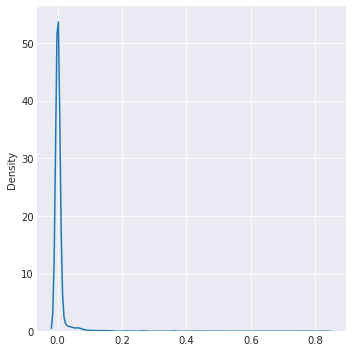

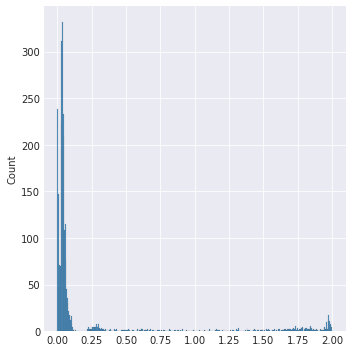

In [77]:
plot_user_similarity(test_series)
plot_users_difference(test_series)

In [78]:
# Как видно, в среднем расстояния отличаются на 2 порядка, что здорово

## Теперь попробуем построить визуализацию:

In [79]:
# Получим вектора вообще для всех пользователей
df_embedded_grouped = df_embedded.groupby('user_id')['name'].mean()
df_embedded_grouped.values

array([array([-4.17052563, -0.97450541]),
       array([-2.69771582,  0.31123963]),
       array([-2.64496153,  0.37540862]), ...,
       array([-2.50764458, -0.42029115]),
       array([-1.8449114 ,  0.22574816]),
       array([-2.37178358,  0.44134818])], dtype=object)

In [80]:
from sklearn.manifold import TSNE
test_serries_embedded = TSNE(n_components = 2, learning_rate = 'auto', init='random', random_state = 42) \
                        .fit_transform(np.stack(df_embedded_grouped.values))

<AxesSubplot:xlabel='embed1', ylabel='embed2'>

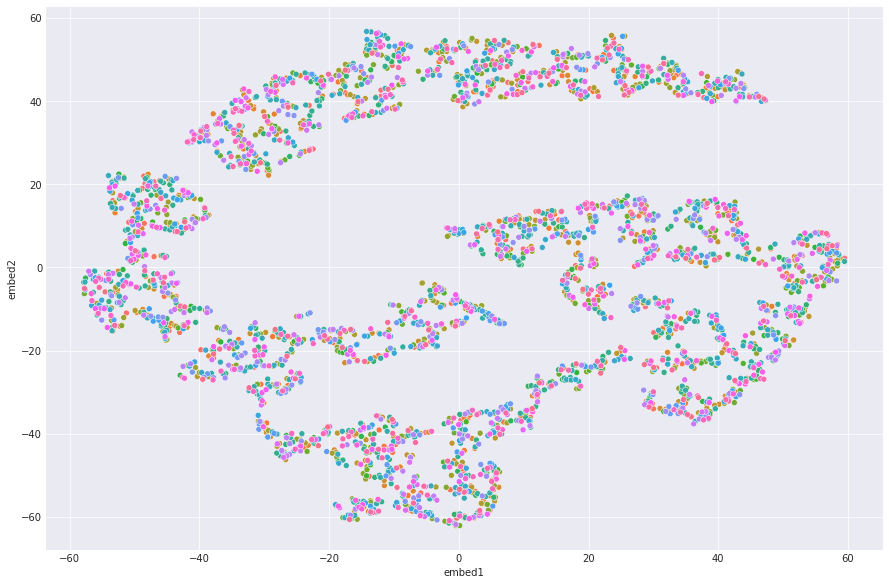

In [81]:
tSNE_test = df_embedded_grouped.reset_index()
tSNE_test['embed1'] = test_serries_embedded[:, 0]
tSNE_test['embed2'] = test_serries_embedded[:, 1]
sns.scatterplot(data = tSNE_test, x = 'embed1', y = 'embed2', hue = 'user_id', legend = False)


<a name = 'clustering'></a>

# Эмбеддинги получены, строим кластеризацию и визуализируем её

## Сделаем PCA компрессию и посмотрим, навредит ли это векторам

In [82]:
# Сделаем PCA компрессию перед кластеризацией, посмотрим не вредит ли это векторам

df_embedded_pca = df_embedded
pca_converter = PCA(n_components = 2, random_state = 42)
df_embedded_pca.name = [x for x in pca_converter.fit_transform(np.vstack(df_embedded.name))]
print(f'Всего сохранилось {round(np.sum(pca_converter.explained_variance_ratio_) , 3)} процентов дисперции')


Всего сохранилось 1.0 процентов дисперции


In [83]:
# Как и прежде проведем тесты
pca_test_df = df_embedded_pca[(df_embedded_pca.user_id.isin(test_people_names)) 
                              & (3 <= df_embedded_pca.lengths) 
                              & (10 >= df_embedded_pca.lengths)]
pca_test_series = pca_test_df.groupby(['user_id','idvisit']).name.sum()
pca_test_series

user_id                               idvisit 
01b527f3-dd4c-40fb-b054-e6af28cdb3e7  52021781      [-1.0623176576002604, 0.9890241847171438]
                                      52279506      [-1.0623176576002604, 0.9890241847171438]
                                      52285375       [-5.28665999371927, 0.08602117129399409]
                                      52287335       [-4.705229183522276, 0.4539949506355665]
                                      52289014      [-2.9470436067354737, 0.4076115270339024]
                                                                     ...                     
f1145ea5-a51d-49c7-bcbe-bd4d3a4faf26  56553053     [-1.5403342837348704, 0.31692329495570254]
                                      56606184     [-2.7679564686628297, -0.5360042818486023]
                                      56709968    [-3.0738061728265476, -0.13127723856251639]
                                      56841365     [-2.7679564686628297, -0.5360042818486023]
             

Максимальное расстояниe между одним и тем же пользователем: 0.6864101010852317 
95й квантиль при этом: 0.03516706289440761 
А в среднем расстояниe между одним и тем же пользователем: 0.007640420483343142 

Минимальное расстояние между разными: 0.00016018801025863283
5й квантиль при этом: 0.0020670972001877517 
А в среднем расстояниe между разными пользователеми: 0.2276657231935937 


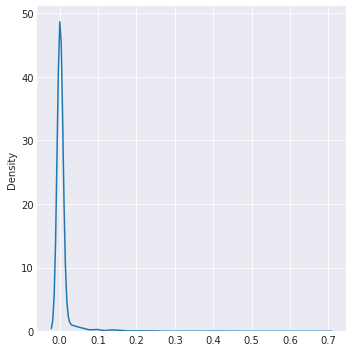

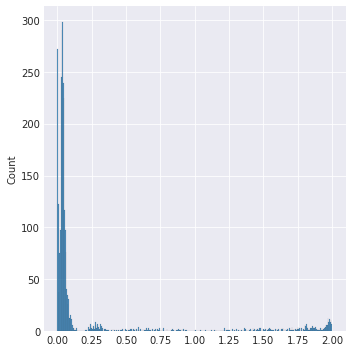

In [84]:
plot_user_similarity(pca_test_series)
plot_users_difference(pca_test_series) 

### Как видно, расстояния в среднем отличаются на 2 порядка

# Применим агломеративную и kNN кластеризации

In [85]:
from sklearn.cluster import KMeans, SpectralClustering

In [86]:
user_embeddings_pca_series = df_embedded_pca.groupby('user_id')['name'].mean()

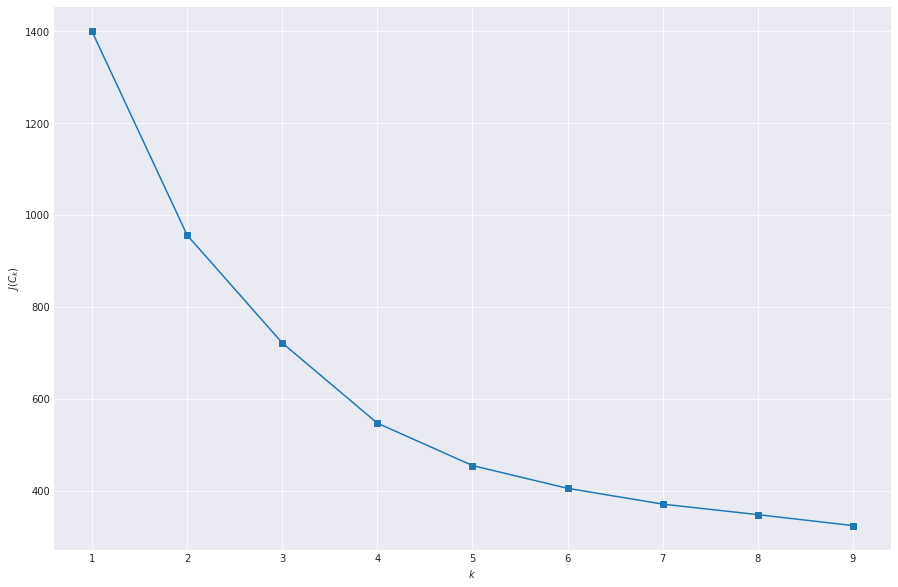

In [87]:
inertia = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit([x for x in user_embeddings_pca_series])
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 10), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [88]:
kmeans_clustering = KMeans(n_clusters = 5, random_state = 42).fit([x for x in user_embeddings_pca_series])
print("labels: \n" , np.unique(kmeans_clustering.labels_))
silhouette_score = metrics.silhouette_score(np.stack(user_embeddings_pca_series), 
                                            kmeans_clustering.labels_, metric='euclidean')
print("silhouette_score: " , silhouette_score)

labels: 
 [0 1 2 3 4]
silhouette_score:  0.7423662191081889


In [89]:
from sklearn.cluster import AffinityPropagation 

AF_clustering = AffinityPropagation(damping = 0.99, max_iter = 3000, random_state = 42) \
            .fit([x for x in user_embeddings_pca_series])

print("labels: \n" , np.unique(AF_clustering.labels_))
silhouette_score = metrics.silhouette_score(np.stack(user_embeddings_pca_series), 
                                            AF_clustering.labels_, metric='euclidean')
print("silhouette_score: " , silhouette_score)

labels: 
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
silhouette_score:  0.722587552244226


In [90]:
def plot_clustering(mode, clustering, pca_embedded_users_df):
    users_clustered = pca_embedded_users_df.reset_index()
    users_clustered["cluster_id"] = clustering.labels_
    users_clustered['embed1'] = np.stack(users_clustered.name)[:, 0]
    users_clustered['embed2'] = np.stack(users_clustered.name)[:, 1]
    if mode == 'pca':
        sns.scatterplot(data = users_clustered, x = 'embed1', y = 'embed2', hue ="cluster_id", legend = True)
    if mode == 'tsne':
         sns.scatterplot(data = tSNE_test, x = 'embed1', y = 'embed2', hue = users_clustered.cluster_id, legend = True)

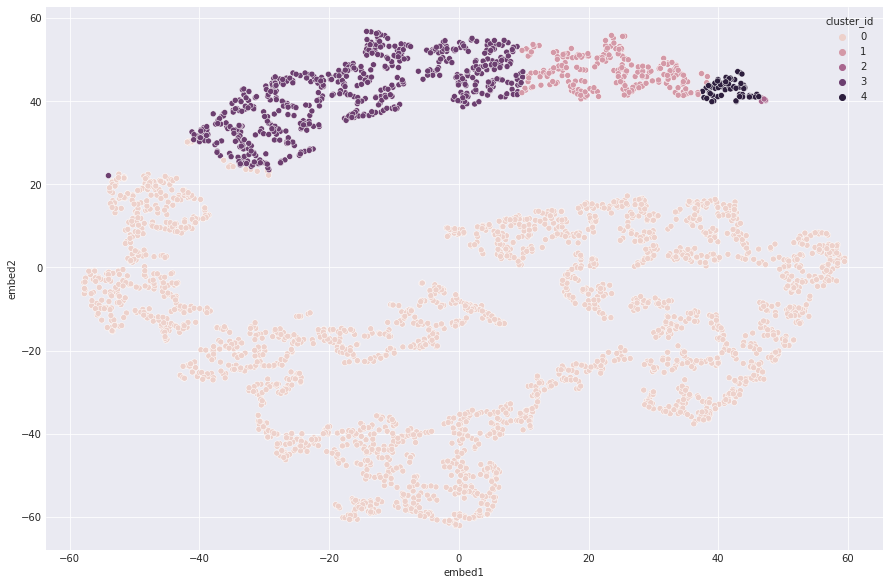

In [91]:
plot_clustering('tsne', kmeans_clustering, user_embeddings_pca_series)


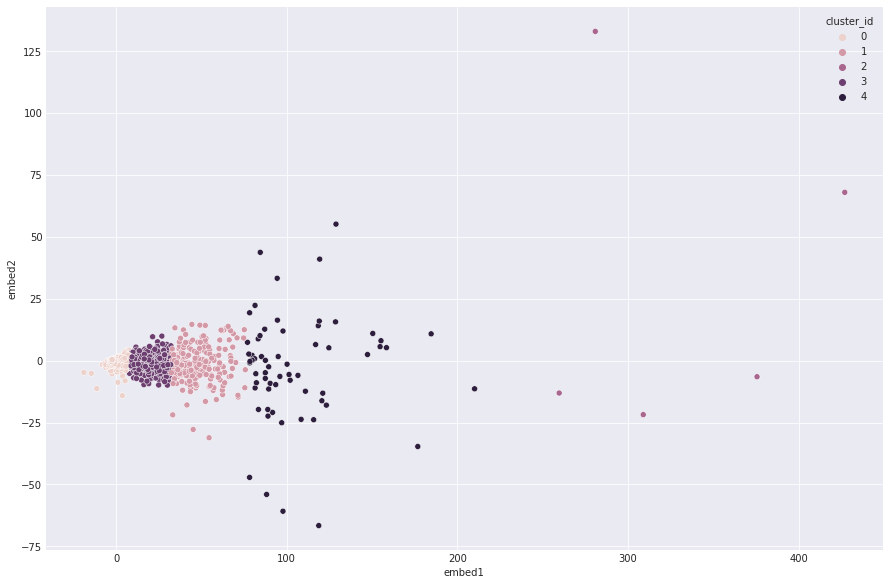

In [92]:
plot_clustering('pca', kmeans_clustering, user_embeddings_pca_series)
